In [ ]:
import torch

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [ ]:
cuda = torch.device('cuda')

In [ ]:
!wget https://github.com/matinfazel/Tumor-Classification/raw/main/Tumor.zip

--2023-12-21 11:13:51--  https://github.com/matinfazel/Tumor-Classification/raw/main/Tumor.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/matinfazel/Tumor-Classification/main/Tumor.zip [following]
--2023-12-21 11:13:51--  https://raw.githubusercontent.com/matinfazel/Tumor-Classification/main/Tumor.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14338568 (14M) [application/zip]
Saving to: ‘Tumor.zip.1’

Tumor.zip.1         100%[===================>]  13.67M  --.-KB/s    in 0.07s   

2023-12-21 11:13:51 (196 MB/s) - ‘Tumor.zip.1’ saved [14338568/14338568]



In [ ]:
# !unzip Tumor.zip

Archive:  Tumor.zip
replace Brain_Tumor/Image1.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import os
from torchvision.io import read_image
from torch.utils.data import Dataset
from PIL import Image
class CustomDataset(Dataset):
    def __init__(self, data_dir ,percent=1, transform = None):
        super().__init__()
        self.data_dir = data_dir
        self.percent = percent 
        self.image_paths = self.get_image_paths()
        self.Transform = transform
        self.Class_names = ["CNV","DME","DRUSEN","NORMAL"]

    def get_image_paths(self):
        image_paths = []
        for root, dir , filenames in os.walk(self.data_dir):
            counter = 0
            for filename in filenames:
                if filename.endswith(".jpeg"):
                    if counter < int(self.percent * len(filenames)):
                        counter += 1
                        image_paths.append(os.path.join(root, filename))
                    else: break
        return image_paths

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        # image = Image.open(image_path)
        image = read_image(image_path).float()
        label = self.get_label(image_path)
        if self.Transform:
            image = self.Transform(image)

        return image, label

    def get_label(self, image_path):
        # Extract the label from the image path
        class_name = os.path.basename(os.path.dirname(image_path))

        # Map class names to class labels, if required
        label_mapping = {
            "CNV": torch.tensor([1,0,0,0] , dtype=torch.float32),
            "DME": torch.tensor([0,1,0,0],dtype=torch.float32),
            "DRUSEN": torch.tensor([0,0,1,0],dtype=torch.float32),
            "NORMAL": torch.tensor([0,0,0,1],dtype=torch.float32)
        }
        label = label_mapping[class_name]

        return label

    def take (self , num ):
        # random index
        rand = torch.randint(len(image_paths)-1 , (num ,))
        # Iterate through samples
        for index in rand :
            yield self.__getitem__(index)


In [ ]:
train_dataset = CustomDataset(data_dir = train_dir , transform=pretrained_vit_transforms , percent=0.3)
test_dataset = CustomDataset(data_dir = test_dir , transform = pretrained_vit_transforms , percent=1)
len(test_dataset) , len(train_dataset)

In [ ]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset , batch_size=BATCH_SIZE , shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE , shuffle=True)

In [ ]:
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import pandas as pds
from torch.utils.data import DataLoader,TensorDataset,random_split

############################################################## Loading Data
n = 3762
image=[]
cw = os.getcwd().replace(os.sep, '/')
trans = transforms.Compose([transforms.ToTensor()])
for i in range(n):
#    image.append(np.asarray(Image.open(cw + "/Brain_Tumor/Image" + str(i+1) + ".jpg")))
    image.append(np.array(Image.open(cw + "/Brain_Tumor/Image" + str(i+1) + ".jpg").resize((48,48))))

temp = pds.read_csv(cw + "/Brain_Tumor.csv",index_col=None, header=None).to_numpy()
temp = temp[1:,1]
targets = np.zeros((n,1),dtype=int)
targets = []
for i in range(n):
    targets.append(int(temp[i]))

data = np.array(image)
data = data/255
data = torch.from_numpy(data).permute((0,3,2,1))
data = data.float().to(cuda)
targets = torch.tensor(targets).to(cuda)
dataset = TensorDataset(data,targets)
batch_size = 4
val_size = int(np.ceil(len(dataset)*0.2))
train_size = len(dataset) - val_size

train_data,test_data = random_split(dataset,[train_size,val_size])

#start your code

train_loader = DataLoader(train_data , batch_size ,shuffle=True)        #Put the train data into a data loader
test_loader = DataLoader(test_data , batch_size ,shuffle=True)         #Put the train data into a data loader
# end

## Visualize data

In [ ]:
pds.read_csv("./Brain_Tumor.csv").Class.value_counts()

0    2079
1    1683
Name: Class, dtype: int64

In [ ]:
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import nn

count of data: 3009
Feature batch shape: torch.Size([4, 3, 48, 48])
Labels batch shape: torch.Size([4])
Shape after Flatten : torch.Size([4, 6912])


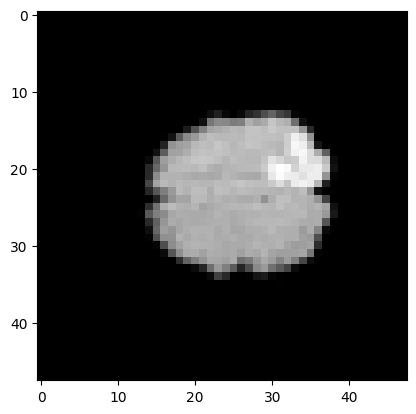

Label: 1


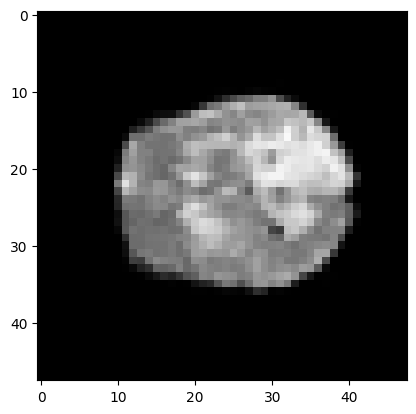

Label: 1


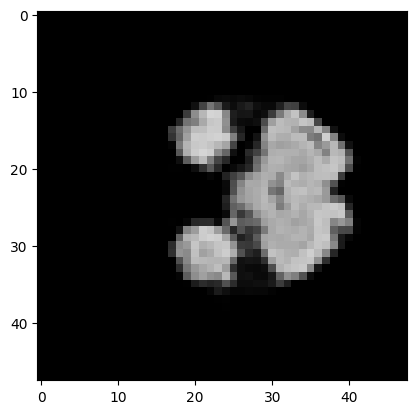

Label: 0


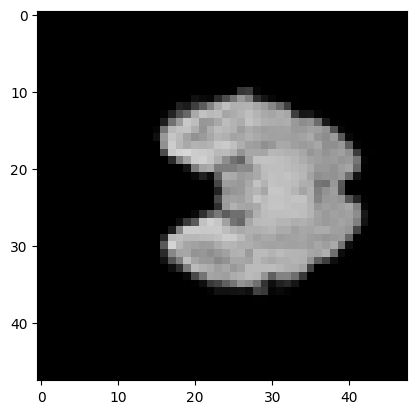

Label: 0


In [ ]:
print("count of data:", len(train_data))
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
print(f"Shape after Flatten : {nn.Flatten()(train_features).shape}")
for i in range(batch_size):
    img = train_features[i].squeeze()
    label = train_labels[i]
    im = transforms.ToPILImage()(img).convert("RGB")

    plt.imshow(im)
    plt.show()
    print(f"Label: {label}")

In [ ]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        #start your code
        self.flatten = nn.Flatten()              # flatten
        # end
        self.linear_relu_stack = nn.Sequential(
            # your code
            nn.Linear(6912 , 512),
            nn.ReLU(),
            nn.Linear(512 , 24),
            nn.ReLU(),
            nn.Linear(24,2),
            # end
        )

    def forward(self, x):
        #start your code
        x = self.flatten(x) # flatten
        logits =  self.linear_relu_stack(x)# linear_relu_satck
        # end
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=6912, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=24, bias=True)
    (3): ReLU()
    (4): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [ ]:
learning_rate = 1e-3
batch_size = 64  # what is this ?
epochs = 100

# your code
loss_fn = nn.CrossEntropyLoss() # CrossEntropy
def build_optimizer(model , learning_rate):
    optimizer = torch.optim.SGD(model.parameters(),lr=learning_rate) # SGD
    return optimizer
# end

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer , config = None):

    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        #start your code
        #prediction
        preds = model(X)
        #loss
        loss = loss_fn(preds , y)
        #loss optimizer
        optimizer.zero_grad()
        #backward
        loss.backward()
        #step
        optimizer.step()
        #end
        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    return test_loss

In [ ]:

losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model, loss_fn, build_optimizer(model , learning_rate))
    loss = test_loop(test_loader, model, loss_fn)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.690117  [    0/ 3009]
loss: 0.674259  [  400/ 3009]
loss: 0.638337  [  800/ 3009]
loss: 0.655854  [ 1200/ 3009]
loss: 0.562291  [ 1600/ 3009]
loss: 0.771485  [ 2000/ 3009]
loss: 0.585165  [ 2400/ 3009]
loss: 0.549257  [ 2800/ 3009]
Test Error: 
 Accuracy: 75.4%, Avg loss: 0.570977 

Epoch 2
-------------------------------
loss: 0.653879  [    0/ 3009]
loss: 0.792328  [  400/ 3009]
loss: 0.555085  [  800/ 3009]
loss: 0.858791  [ 1200/ 3009]
loss: 0.369696  [ 1600/ 3009]
loss: 0.770016  [ 2000/ 3009]
loss: 0.437543  [ 2400/ 3009]
loss: 0.543532  [ 2800/ 3009]
Test Error: 
 Accuracy: 72.8%, Avg loss: 0.524958 

Epoch 3
-------------------------------
loss: 0.284106  [    0/ 3009]
loss: 0.400078  [  400/ 3009]
loss: 0.250819  [  800/ 3009]
loss: 0.700529  [ 1200/ 3009]
loss: 0.200724  [ 1600/ 3009]
loss: 0.515259  [ 2000/ 3009]
loss: 1.258090  [ 2400/ 3009]
loss: 0.225964  [ 2800/ 3009]
Test Error: 
 Accuracy: 77.4%, Avg loss: 0.496466 

Epoc

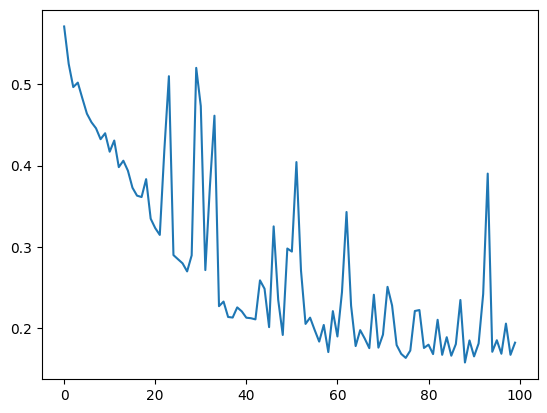

In [ ]:
plt.plot(np.arange(0,100),losses)

In [ ]:
class NeuralNetwork2(nn.Module):
    def __init__(self):
        super(NeuralNetwork2, self).__init__()
        self.stack = nn.Sequential(
            #start your code
            nn.Conv2d(3,32,3,1,1),
            nn.ReLU(),
            nn.Conv2d(32,64,3,1,1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Flatten(),
            nn.Linear(36_864 , 512),
            nn.ReLU(),
            nn.Linear(512 , 24),
            nn.ReLU(),
            nn.Linear(24 ,2 )
            # end
        )

    def forward(self, x):
        logits = self.stack(x)
        return logits

In [ ]:
model2 = NeuralNetwork2().to(cuda)
print(model2)

NeuralNetwork2(
  (stack): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=36864, out_features=512, bias=True)
    (7): ReLU()
    (8): Linear(in_features=512, out_features=24, bias=True)
    (9): ReLU()
    (10): Linear(in_features=24, out_features=2, bias=True)
  )
)


In [ ]:
losses=[]
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_loader, model2, loss_fn, build_optimizer(model2 , learning_rate))

    loss = test_loop(test_loader, model2, loss_fn)
    losses.append(loss)
print("Done!")

Epoch 1
-------------------------------
loss: 0.694249  [    0/ 3009]
loss: 0.695396  [  400/ 3009]
loss: 0.658555  [  800/ 3009]
loss: 0.684262  [ 1200/ 3009]
loss: 0.652700  [ 1600/ 3009]
loss: 0.727973  [ 2000/ 3009]
loss: 0.589608  [ 2400/ 3009]
loss: 0.593111  [ 2800/ 3009]
Test Error: 
 Accuracy: 55.0%, Avg loss: 0.673495 

Epoch 2
-------------------------------
loss: 0.593506  [    0/ 3009]
loss: 0.638055  [  400/ 3009]
loss: 0.682097  [  800/ 3009]
loss: 0.634624  [ 1200/ 3009]
loss: 0.711995  [ 1600/ 3009]
loss: 0.697354  [ 2000/ 3009]
loss: 0.563267  [ 2400/ 3009]
loss: 0.740802  [ 2800/ 3009]
Test Error: 
 Accuracy: 61.8%, Avg loss: 0.637627 

Epoch 3
-------------------------------
loss: 0.627057  [    0/ 3009]
loss: 0.582832  [  400/ 3009]
loss: 0.586425  [  800/ 3009]
loss: 0.622320  [ 1200/ 3009]
loss: 0.622441  [ 1600/ 3009]
loss: 0.666410  [ 2000/ 3009]
loss: 0.565490  [ 2400/ 3009]
loss: 0.467114  [ 2800/ 3009]
Test Error: 
 Accuracy: 76.0%, Avg loss: 0.539224 

Epoc

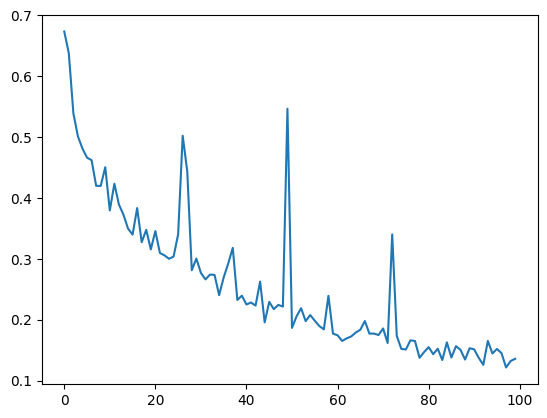

In [ ]:
plt.plot(np.arange(0,100),losses)

what is the diffrence ?
we have less noise in second model and it has a little better performance 

In [ ]:
!pip install wandb
import wandb

## WandB

In [ ]:
!wandb login cfa61dfee26b7bf9fbe8d11b14248ef541558

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# !wandb init(
#     # set the wandb project where this run will be logged
#     project = "MRI_CI_LAB"
# )

In [ ]:
sweep_config = {
    'method' : 'random'
}

In [ ]:
parameters_dict = {
    'learning_rate' : {
        'distribution' : 'uniform' ,
        'min' : 0.00005,
        'max' : 0.001
    }
}
sweep_config['parameters'] = parameters_dict

In [ ]:
import pprint
pprint.pprint(sweep_config)

{'method': 'random',
 'parameters': {'learning_rate': {'distribution': 'uniform',
                                  'max': 0.001,
                                  'min': 5e-05}}}


In [ ]:
def train(config=None , model = model2 , train_loader = train_loader , test_loader = test_loader , loss_fn = loss_fn):
    with wandb.init(config=config):
        config = wandb.config
        losses=[]
        for t in range(epochs):
            print(f"Epoch {t+1}\n-------------------------------")
            train_loop(train_loader, model, loss_fn, build_optimizer(model , config.learning_rate))

            loss = test_loop(test_loader, model, loss_fn)
            wandb.log({"loss" : loss , "epoch" : i })
            losses.append(loss)

In [ ]:
sweep_id = wandb.sweep(sweep_config, project="MRI_CI_LAB")
try :
  wandb.agent(sweep_id , train , count=5)
except Exception as e :
  wandb.socket.close()
  raise e

Create sweep with ID: i1a7tcfq
Sweep URL: https://wandb.ai/amirali/MRI_CI_LAB/sweeps/i1a7tcfq


wandb: Agent Starting Run: iwlbqpht with config:
wandb: 	learning_rate: 0.00016311417094374702
wandb: Currently logged in as: amiraliarbab1831 (amirali). Use `wandb login --relogin` to force relogin


Epoch 1
-------------------------------
loss: 0.008974  [    0/ 3009]
loss: 0.000169  [  400/ 3009]
loss: 0.001432  [  800/ 3009]
loss: 0.017995  [ 1200/ 3009]
loss: 0.170658  [ 1600/ 3009]
loss: 0.042944  [ 2000/ 3009]
loss: 0.022932  [ 2400/ 3009]
loss: 0.004916  [ 2800/ 3009]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.127158 

Epoch 2
-------------------------------
loss: 0.051149  [    0/ 3009]
loss: 0.002535  [  400/ 3009]
loss: 0.000358  [  800/ 3009]
loss: 0.067330  [ 1200/ 3009]
loss: 0.009514  [ 1600/ 3009]
loss: 0.021719  [ 2000/ 3009]
loss: 0.004498  [ 2400/ 3009]
loss: 0.000043  [ 2800/ 3009]
Test Error: 
 Accuracy: 95.9%, Avg loss: 0.129671 

Epoch 3
-------------------------------
loss: 0.061330  [    0/ 3009]
loss: 0.044152  [  400/ 3009]
loss: 0.001321  [  800/ 3009]
loss: 0.019081  [ 1200/ 3009]
loss: 0.000329  [ 1600/ 3009]
loss: 0.319821  [ 2000/ 3009]
loss: 0.016100  [ 2400/ 3009]
loss: 0.036549  [ 2800/ 3009]
Test Error: 
 Accuracy: 95.4%, Avg loss: 0.130629 

Epoc

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▂▂▂▃▂▃▂▃▂▅▂▄▃▃▃▄▄▃▅▄▄▄▆▅█▇▅▅▇▅▆▅▆▇▅▇▇▆▇
epoch,3
loss,0.15253


wandb: Agent Starting Run: c21zf6bf with config:
wandb: 	learning_rate: 0.0004489817168100679


Epoch 1
-------------------------------
loss: 0.000249  [    0/ 3009]
loss: 0.022886  [  400/ 3009]
loss: 0.002741  [  800/ 3009]
loss: 0.001893  [ 1200/ 3009]
loss: 0.022942  [ 1600/ 3009]
loss: 0.000827  [ 2000/ 3009]
loss: 0.002227  [ 2400/ 3009]
loss: 0.007952  [ 2800/ 3009]
Test Error: 
 Accuracy: 95.6%, Avg loss: 0.154826 

Epoch 2
-------------------------------
loss: 0.000363  [    0/ 3009]
loss: 0.000001  [  400/ 3009]
loss: 0.000001  [  800/ 3009]
loss: 0.000255  [ 1200/ 3009]
loss: 0.000009  [ 1600/ 3009]
loss: 0.001470  [ 2000/ 3009]
loss: 0.000079  [ 2400/ 3009]
loss: 0.005452  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.155193 

Epoch 3
-------------------------------
loss: 0.009638  [    0/ 3009]
loss: 0.000014  [  400/ 3009]
loss: 0.000079  [  800/ 3009]
loss: 0.005423  [ 1200/ 3009]
loss: 0.000928  [ 1600/ 3009]
loss: 0.040054  [ 2000/ 3009]
loss: 0.001920  [ 2400/ 3009]
loss: 0.240928  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.148526 

Epoc

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▂▁▃▂▆▅▃▄▃▃▂▂▄▃▃▃▃▄▄▄▆▄▄▅▄▆▆▅▇▅▆▅▆█▇▆▆▇▆▇
epoch,3
loss,0.20423


wandb: Agent Starting Run: n9joggbr with config:
wandb: 	learning_rate: 0.00035098726310255453


Epoch 1
-------------------------------
loss: 0.001349  [    0/ 3009]
loss: 0.000771  [  400/ 3009]
loss: 0.000463  [  800/ 3009]
loss: 0.000178  [ 1200/ 3009]
loss: 0.002940  [ 1600/ 3009]
loss: 0.000066  [ 2000/ 3009]
loss: 0.000009  [ 2400/ 3009]
loss: 0.002808  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.195717 

Epoch 2
-------------------------------
loss: 0.001022  [    0/ 3009]
loss: 0.000002  [  400/ 3009]
loss: 0.000001  [  800/ 3009]
loss: 0.012457  [ 1200/ 3009]
loss: 0.000000  [ 1600/ 3009]
loss: 0.000002  [ 2000/ 3009]
loss: 0.000127  [ 2400/ 3009]
loss: 0.000000  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.197098 

Epoch 3
-------------------------------
loss: 0.000048  [    0/ 3009]
loss: 0.000055  [  400/ 3009]
loss: 0.000001  [  800/ 3009]
loss: 0.000010  [ 1200/ 3009]
loss: 0.000002  [ 1600/ 3009]
loss: 0.024498  [ 2000/ 3009]
loss: 0.002747  [ 2400/ 3009]
loss: 0.001161  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.205585 

Epoc

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▂▁▂▂▂▂▃▄▂▃▂▃▃▃▄▄▃▄▄▄▅▄▄▄▃▅▃▃▄▅▅▄▅▅█▄▅▆▅
epoch,3
loss,0.22328


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 6srai5wy with config:
wandb: 	learning_rate: 0.0004648150808940979


Epoch 1
-------------------------------
loss: 0.002636  [    0/ 3009]
loss: 0.002276  [  400/ 3009]
loss: 0.000326  [  800/ 3009]
loss: 0.000156  [ 1200/ 3009]
loss: 0.000039  [ 1600/ 3009]
loss: 0.000035  [ 2000/ 3009]
loss: 0.000589  [ 2400/ 3009]
loss: 0.000000  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.235111 

Epoch 2
-------------------------------
loss: 0.000560  [    0/ 3009]
loss: 0.000002  [  400/ 3009]
loss: 0.000003  [  800/ 3009]
loss: 0.000032  [ 1200/ 3009]
loss: 0.000004  [ 1600/ 3009]
loss: 0.000000  [ 2000/ 3009]
loss: 0.000000  [ 2400/ 3009]
loss: 0.000284  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.228522 

Epoch 3
-------------------------------
loss: 0.000003  [    0/ 3009]
loss: 0.000012  [  400/ 3009]
loss: 0.000000  [  800/ 3009]
loss: 0.000000  [ 1200/ 3009]
loss: 0.002845  [ 1600/ 3009]
loss: 0.001182  [ 2000/ 3009]
loss: 0.000050  [ 2400/ 3009]
loss: 0.000309  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.3%, Avg loss: 0.226749 

Epoc

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▄▂▂▂▂▁▂▁▃▂▁▂▂▃▃▃▄▃▂▅▄▃▄▂▄▄▅▄▄▇▄▄▅█▅▃▅▅▆▆
epoch,3
loss,0.24244


wandb: Agent Starting Run: 2z8nn46t with config:
wandb: 	learning_rate: 0.0005900669269670262


Epoch 1
-------------------------------
loss: 0.005284  [    0/ 3009]
loss: 0.000000  [  400/ 3009]
loss: 0.000028  [  800/ 3009]
loss: 0.000025  [ 1200/ 3009]
loss: 0.000000  [ 1600/ 3009]
loss: 0.000205  [ 2000/ 3009]
loss: 0.000060  [ 2400/ 3009]
loss: 0.000650  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.238935 

Epoch 2
-------------------------------
loss: 0.000000  [    0/ 3009]
loss: 0.000001  [  400/ 3009]
loss: 0.000362  [  800/ 3009]
loss: 0.000064  [ 1200/ 3009]
loss: 0.000105  [ 1600/ 3009]
loss: 0.000000  [ 2000/ 3009]
loss: 0.000000  [ 2400/ 3009]
loss: 0.001001  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.4%, Avg loss: 0.252647 

Epoch 3
-------------------------------
loss: 0.000073  [    0/ 3009]
loss: 0.000018  [  400/ 3009]
loss: 0.000020  [  800/ 3009]
loss: 0.000000  [ 1200/ 3009]
loss: 0.000000  [ 1600/ 3009]
loss: 0.000000  [ 2000/ 3009]
loss: 0.000169  [ 2400/ 3009]
loss: 0.000000  [ 2800/ 3009]
Test Error: 
 Accuracy: 96.1%, Avg loss: 0.237680 

Epoc

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,▁▁▃▃▂▂▃▁▃▄▄▃▃▄▂█▃▃▂▄▃▄▄▃▄▃▅▄▄▅▄▅▄▅▅▅▆▄▄▅
epoch,3
loss,0.25796


In [ ]:
wandb.finish()